In [2]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma,powerlognorm
import warnings
%pylab inline
warnings.simplefilter('ignore')

Populating the interactive namespace from numpy and matplotlib


##### Полученные по модели Precision и Recall

##### График плотности распределения случайной величины 'Доход от пользователя в месяц'

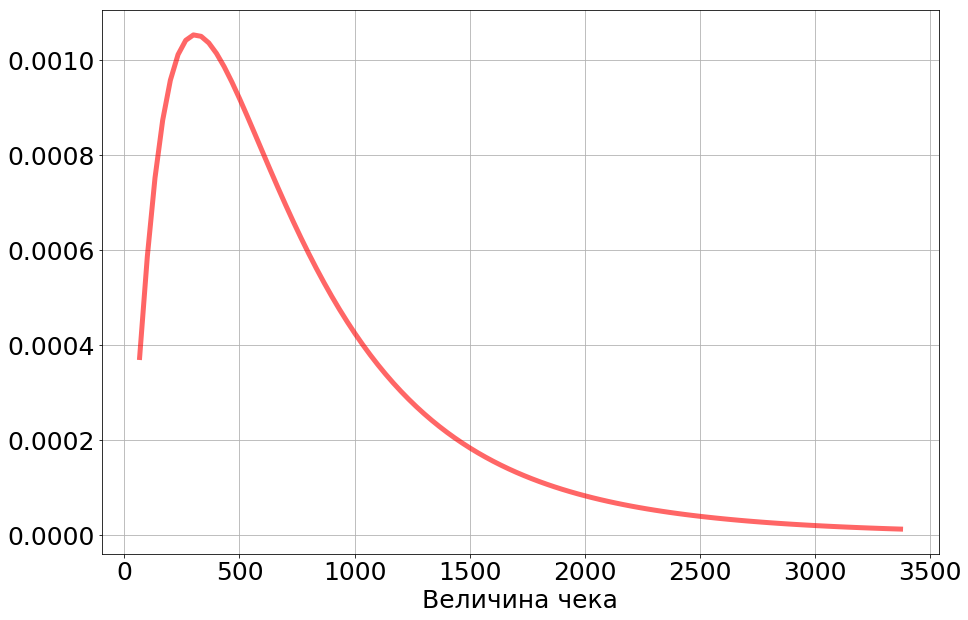

In [3]:
c, s,loc,scale = 6, 1.3,0,3000
x = np.linspace(0, 1, 100)

x = np.linspace(powerlognorm.ppf(0.01, c, s,loc,scale ),
                powerlognorm.ppf(0.99, c, s,loc,scale ), 100)
plt.figure(figsize=(15,10))
plt.grid()
plt.legend(loc="best")
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.xlabel(u'Величина чека',fontsize = 25)
plt.plot(x, powerlognorm.pdf(x, c, s,loc,scale ),'r-', lw=5, alpha=0.6, label='profit pdf')
plt.show()

Средний месячный чек в рублях:

In [4]:
powerlognorm.mean(c, s,loc,scale)

798.01606007975806

Средне месячый чек Top 5% пользователей в рублях:

In [5]:
Top = 0.05
powerlognorm.ppf(1-Top, c, s,loc,scale)

2108.0829816330979

Стоимость удержания:

In [7]:
Cost_of_retention = 300
#p = Cost_of_retention/profit  

Функция вероятности принятия предложения о продолжении использования услуги в зависимости от размера скидки в долях от дохода приносимого пользователем:

In [8]:
def Accept_probability(p):
    return math.e**(-0.2/p)

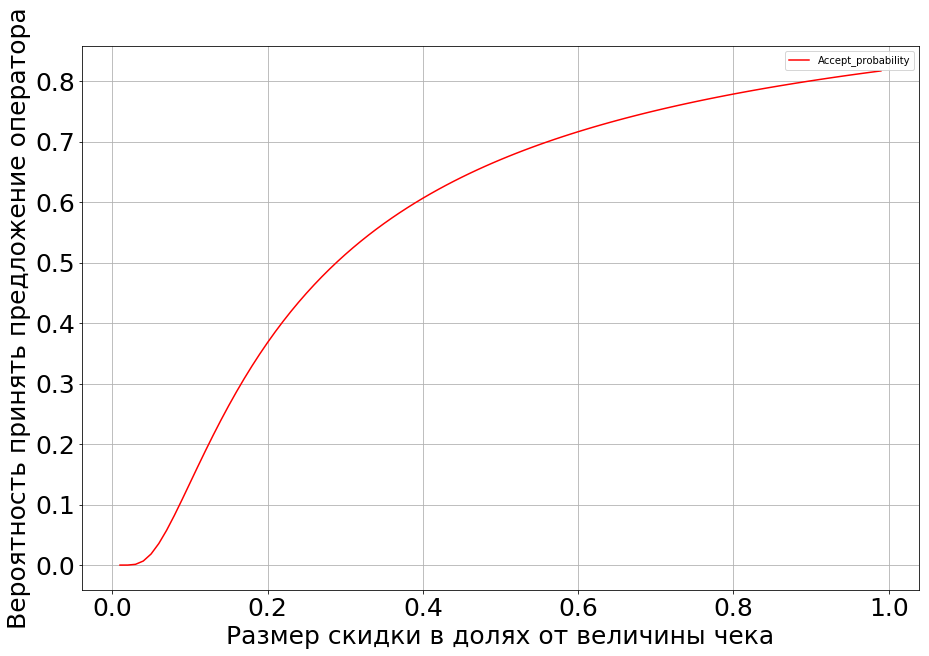

In [9]:
plt.figure(figsize=(15,10))
plt.xlabel(u"Размер скидки в долях от величины чека",fontsize = 25)
plt.ylabel(u"Вероятность принять предложение оператора",fontsize = 25)
plt.grid()
plt.legend(loc="best")
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.plot([x/100. for x in xrange(1,100)],[Accept_probability(x/100.) for x in xrange(1,100) ], 'w-', color="r",\
             label="Accept_probability")

plt.legend(loc="best")
plt.show()

Кривая на мой взгляд довольно разумна. Некоторых клиентов не остановить ни какими скидками: возможно они сменили место жительства или вообще не нуждаются в предлагаемой услуге. А скидка к 3-5% никого не остановит. 

    В итоге у нас получилось четые свободных параметра: 
        Precision 
        Recall 
        Cost_of_retention - стоимость на удержания клиента 
        Top - доля пользователей с наибольшим доходом

In [10]:
users = 40000
churn = users*0.0744

In [11]:
Precision = 0.42 #  TP / (TP + FP)
Recall = 0.1  #  TP / (TP + FN)
support = (Recall*churn)//1

In [12]:
print support

297.0


In [13]:
def get_profit(Precision, Recall, Cost_of_retention, Top):

    TP =  Recall*support
    FP =  (TP/Precision)-TP
    lower_boundary = powerlognorm.ppf(1-Top, c, s,loc,scale)
   
    mean = powerlognorm.expect(args=(c, s), loc=loc, scale=scale, lb=lower_boundary, conditional=True)
    p = Cost_of_retention/mean

    return Top*TP*(2*mean-Cost_of_retention)*Accept_probability(p) - Top*FP*Cost_of_retention - 2*((TP+FP)*Top)**1.9

In [15]:
get_profit(Precision, Recall, 360, 0.56)

6854.4074851466285

 $$ Top\cdot FP \cdot CostOfRetention $$  - потери от скидок предлагаемых клиентам которые уходить не собирались.
 
 $$ Top \cdot TP\cdot(2 \cdot mean - CostOfRetention)\cdot AcceptProbability( p )$$  - доход от клиентов которые решились принять предложение, множитель 2 означает, что они остаются с нами еще на 2 месяца, после получения бонуса
 
 $$ 2\cdot(TP+FP)^{1.9}  $$ - накладные расходы, растут от колличества совершенных предложений, иными словами стоимость рассылки или необходимого количества телефонных звонков.

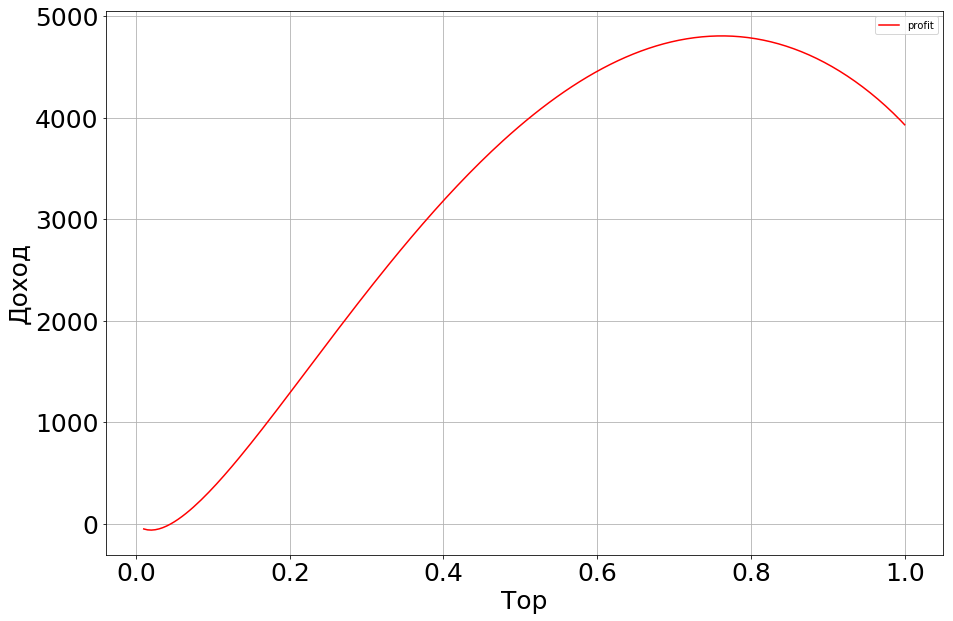

In [17]:
plt.figure(figsize=(15,10))
plt.xlabel(u"Top",fontsize = 25)
plt.ylabel(u"Доход",fontsize = 25)
plt.grid()
plt.legend(loc="best")
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
ls = np.linspace(0.01,1,200)

plt.plot(ls,[get_profit(Precision, Recall, 200, x) for x in ls], 'w-', color="r",\
             label="profit")

plt.legend(loc="best")
plt.show()

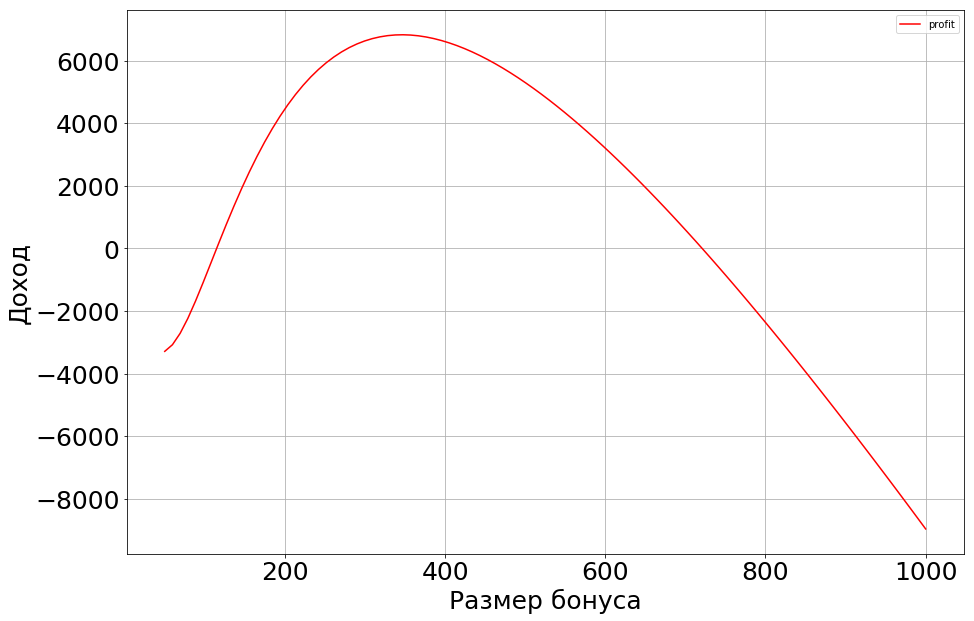

In [18]:
plt.figure()
plt.figure(figsize=(15,10))
plt.xlabel(u"Размер бонуса",fontsize = 25)
plt.ylabel(u"Доход",fontsize = 25)
plt.grid()
plt.legend(loc="best")
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)

ls = np.linspace(50,1000,100)

plt.plot(ls,[get_profit(Precision, Recall, x, 0.6) for x in ls], 'w-', color="r",\
             label="profit")

plt.legend(loc="best")
plt.show()

Оптимальный cost 250

In [21]:
X =[]
Y =[]
Z =[]
for top in  np.linspace(0.01, 1, 100):
    for cost in np.linspace(50, 700, 100):
        X.append(top)
        Y.append(cost)
        Z.append(get_profit(Precision, Recall, cost, top))


In [22]:
m = -100
pos=0
for i in xrange(0,len(Z)):
    if Z[i] > m:
        m=Z[i]
        pos = i  

In [23]:
max(Z)

6854.2706169535122

In [24]:
print Y[pos],X[pos], Z[pos]

358.585858586 0.56 6854.27061695


In [25]:
from mpl_toolkits.mplot3d import axes3d, Axes3D

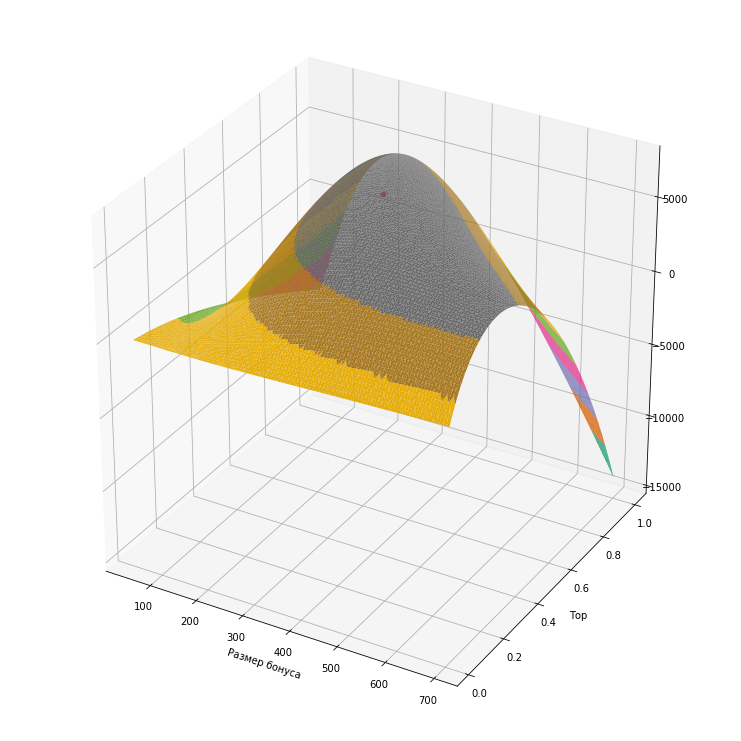

In [26]:
fig = plt.figure(figsize=(10,10))
ax = Axes3D(fig)
plt.xlabel(u"Размер бонуса",fontsize = 10)
plt.ylabel(u"Top",fontsize = 10)
ax.scatter(Y[pos],X[pos], Z[pos],s=20, color = 'r', marker = "o")
surf = ax.plot_trisurf(Y,X, Z,cmap=cm.Dark2, linewidth=3,alpha=1)
#ax

plt.show()

#### Красная точка - максимум. 

    Результаты трехмерной оптимизации
    cost = 358
    Top = 0.56
    profit = 6800


In [177]:
get_profit(Precision, Recall,  360, 0.56)

6854.4074851466285

Увеличение точности и полноты на 1% и 3% 

In [180]:
get_profit(Precision+0.01, Recall,360, 0.56)

7280.8636343702456

In [181]:
get_profit_v2(Precision, Recall+0.01, 360, 0.56)

7325.9608435630398

In [182]:
get_profit(Precision+0.03, Recall,360, 0.56)

8071.5268280280989

In [185]:
get_profit(Precision, Recall+0.03,360, 0.56)

8159.0646467375991

### Замечания


        Доходность модели составила 7 тыс. руб. 8 среднемесячных чека. 8  чеков на 156 человек участвовавших в компании по удержанию.  Рост точности значительно увеличивает доходность модели.   Из графиков  и трехмерной поверхности видно узкую область параметров применимости модели.
     